In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize as imresize
from skimage.color import gray2rgb
from matplotlib import pyplot as plt
from multiprocessing import Pool
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import keras
from keras.models import Model
from keras.layers import Dense
import keras.backend as K
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from sklearn.utils import shuffle as skl_shuffle
K.set_session(session)

DATASET_ROOT = '/hdd/dataset/ML_HW2/CroppedYale/'
SPLIT_P = 35

/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Construct filepaths.
label_name = sorted(next(os.walk(DATASET_ROOT))[1])
CLASS_N = len(label_name)
W, H = 224, 224 # use default imagenet dimensions
EPOCHS = 12
BATCH_SIZE = 16

In [3]:
def read_img(filename):
    img = imread(filename, as_grey=True)
    img = gray2rgb(img)
    if img.shape[0] != H or img.shape[1] != W:
        order = 1 if img.shape[0]<H or img.shape[1]<W else 0
        img = imresize(img, (H,W), order=order, preserve_range=True) # resize
    return img.astype(np.float32)

In [4]:
# Load images and split into train/val sets.
X_train, X_test, Y_train, Y_test = [], [], [], []
for id_, name in tqdm(enumerate(label_name), total=len(label_name)):
    img_paths = glob.glob(DATASET_ROOT+name+'/*.pgm')
    np.random.shuffle(img_paths)
    train_paths, test_paths = img_paths[:SPLIT_P], img_paths[SPLIT_P:]
    X_train.extend([read_img(img_path) for img_path in train_paths])
    Y_train.extend([id_]*len(train_paths))
    X_test.extend([read_img(img_path) for img_path in test_paths])
    Y_test.extend([id_]*len(test_paths))
X_train, X_test, Y_train, Y_test = list(map(np.asarray, [X_train, X_test, Y_train, Y_test]))
X_train, X_test = list(map(preprocess_input, [X_train, X_test])) # substract mean, etc.
Y_train, Y_test = list(map(lambda x: to_categorical(x, num_classes=CLASS_N), [Y_train, Y_test]))

  0%|          | 0/38 [00:00<?, ?it/s]/hdd/home/peter0749/virtualenv/tf_keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 38/38 [00:09<00:00,  4.05it/s]


In [5]:
def make_vgg16(weights=None):
    # default initializers of convolution layer in Keras are
    # kernel_initializer='glorot_uniform', bias_initializer='zeros
    model = VGG16(classes=1, include_top=True, input_shape=(H,W,3), weights=None) # random initialization
    if not weights is None:
        model.load_weights(weights, by_name=True)
        for layer in model.layers[:-9]:
            layer.trainable = False # Freeze all pre-trained layers except fc1
    out = Dense(CLASS_N, activation='softmax') (model.layers[-3].output) # output layer
    return Model(model.inputs, out)

In [6]:
def plot_loss(history):
    fig, ax = plt.subplots(2, 1, dpi=150)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('model loss')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train','valid'], loc='upper right')
    
    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])
    ax[1].set_title('model accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train','valid'], loc='lower right')
    plt.tight_layout()
    plt.show()

In [7]:
# default initializers of convolution layer in Keras are
# kernel_initializer='glorot_uniform', bias_initializer='zeros'
vgg16_random = make_vgg16()
vgg16_fine_tune = make_vgg16(weights='/hdd/dataset/ML_HW2/model.h5')
vgg16_fine_tune.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Train on 1330 samples, validate on 1122 samples
Epoch 1/12
1330/1330 [==============================] - 25s 18ms/step - loss: 3.6171 - acc: 0.0271 - val_loss: 3.4845 - val_acc: 0.0588
Epoch 2/12
1330/1330 [==============================] - 22s 17ms/step - loss: 3.2524 - acc: 0.1248 - val_loss: 3.3883 - val_acc: 0.1872
Epoch 3/12
1330/1330 [==============================] - 22s 17ms/step - loss: 2.1931 - acc: 0.4045 - val_loss: 2.0383 - val_acc: 0.4982
Epoch 4/12
1330/1330 [==============================] - 22s 17ms/step - loss: 1.1034 - acc: 0.6992 - val_loss: 1.1779 - val_acc: 0.7059
Epoch 5/12
1330/1330 [==============================] - 22s 17ms/step - loss: 0.5648 - acc: 0.8481 - val_loss: 0.9619 - val_acc: 0.7585
Epoch 6/12
1330/1330 [==============================] - 22s 17ms/step - loss: 0.3837 - acc: 0.8902 - val_loss: 1.0473 - val_acc: 0.8012
Epoch 7/12
1330/1330 [==============================] - 22s 17ms/step - loss: 0.3055 - acc: 0.9195 - val_loss: 0.9014 - val_acc: 0.7977


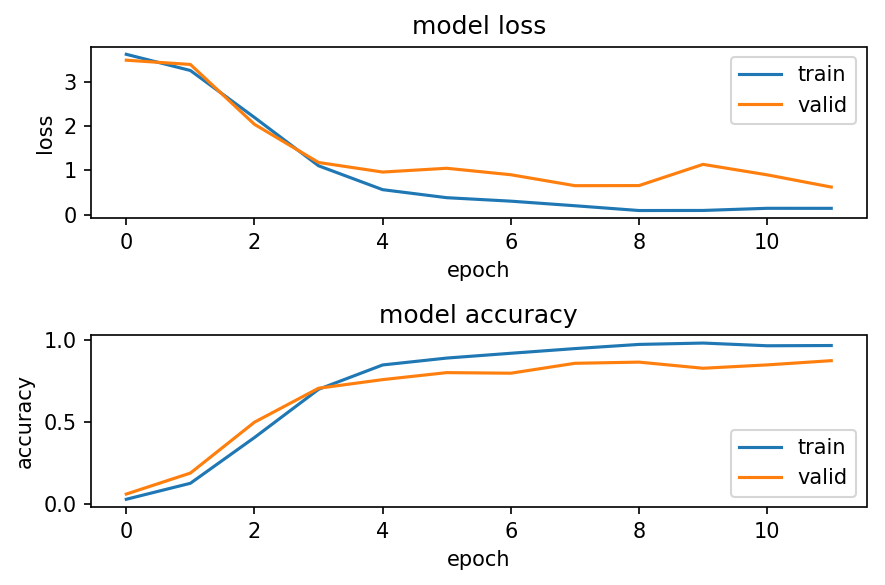

In [8]:
## Train random:
vgg16_random.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])
vgg16_random_history = vgg16_random.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True)
plot_loss(vgg16_random_history)

Train on 1330 samples, validate on 1122 samples
Epoch 1/12
1330/1330 [==============================] - 15s 11ms/step - loss: 2.6782 - acc: 0.4466 - val_loss: 0.4949 - val_acc: 0.8636
Epoch 2/12
1330/1330 [==============================] - 15s 11ms/step - loss: 0.2370 - acc: 0.9368 - val_loss: 0.3383 - val_acc: 0.9100
Epoch 3/12
1330/1330 [==============================] - 15s 11ms/step - loss: 0.0942 - acc: 0.9774 - val_loss: 0.2050 - val_acc: 0.9554
Epoch 4/12
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1373 - acc: 0.9669 - val_loss: 0.7734 - val_acc: 0.8636
Epoch 5/12
1330/1330 [==============================] - 15s 11ms/step - loss: 0.1090 - acc: 0.9744 - val_loss: 0.3295 - val_acc: 0.9180
Epoch 6/12
1330/1330 [==============================] - 15s 11ms/step - loss: 0.0424 - acc: 0.9910 - val_loss: 0.2353 - val_acc: 0.9554
Epoch 7/12
1330/1330 [==============================] - 15s 11ms/step - loss: 0.0036 - acc: 0.9992 - val_loss: 0.2251 - val_acc: 0.9599


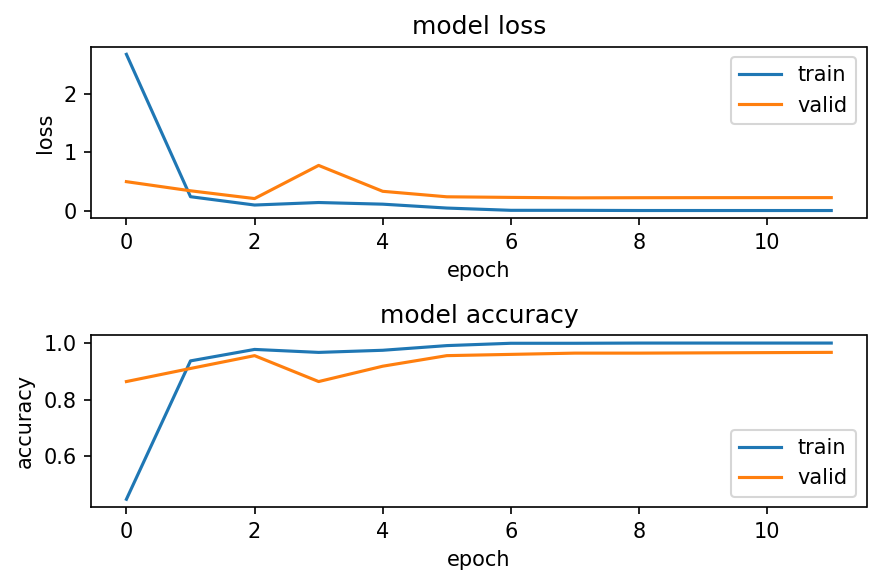

In [9]:
## Train fine-tune:
vgg16_fine_tune.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])
vgg16_fine_tune_history = vgg16_fine_tune.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True)
plot_loss(vgg16_fine_tune_history)